<a href="https://www.kaggle.com/code/gautammdiwan/mask-detection-using-rapids?scriptVersionId=90457269" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import cudf as cd
import cupy as cp
import glob
import cv2
from IPython.display import clear_output
from matplotlib import pyplot as plt
from cuml.ensemble import RandomForestClassifier
from cuml.metrics import roc_auc_score,confusion_matrix,mean_squared_log_error,precision_recall_curve
from sklearn.metrics import classification_report


In [3]:
path = "../input/face-mask-12k-images-dataset/Face Mask Dataset/"
os.listdir(path)

['Validation', 'Test', 'Train']

In [4]:
model_metrics={}

## Storing the path, target values and the location for the image data

glob library is used as it finds all the pathnames matching a specified pattern according to the rules used by the Unix shell similar to regular expressions

In [5]:
image_path = []
label = []
location = []

for where in os.listdir(path):
    for status in os.listdir(path+"/"+where):
        for image in glob.glob(path+where+"/"+status+"/"+"*.png"):
            image_path.append(image)
            label.append(status)
            location.append(where)
            
data = cd.DataFrame({'image_path':image_path,'label':label,'location':location})
data.head()

,image_path,label,location
0,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
1,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
2,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
3,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
4,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation


## Splitting the data based upon Training, Testing and validation. Sampling is done to minimize the class imbalances

In [6]:
train_data =data[data['location']=='Train'].sample(frac=1)
test_data = data[data['location']=='Test'].sample(frac=1)
validation_data = data[data['location']=='Validation'].sample(frac=1)

# EDA

In [7]:
def plot_images(data):
    for loc in range(4):
        plt.imshow(cv2.imread(data.iloc[loc,0]))
        plt.title(f'{data.iloc[loc,2]}-{data.iloc[loc,1]}')
        plt.show()

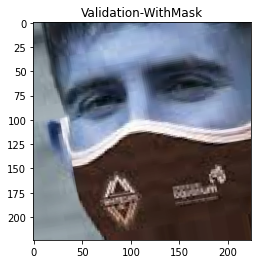

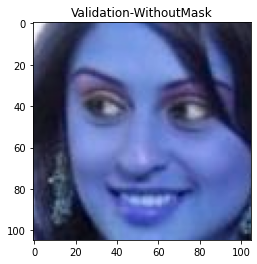

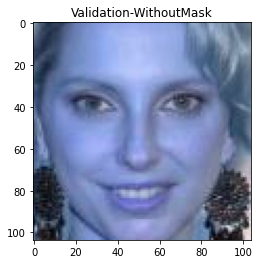

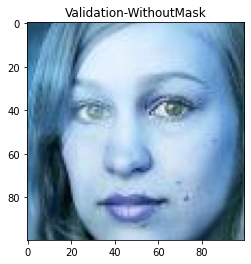

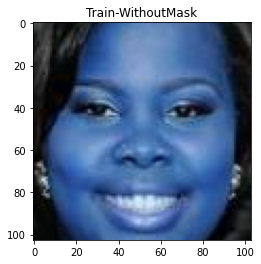

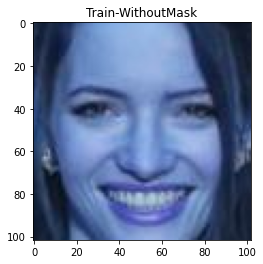

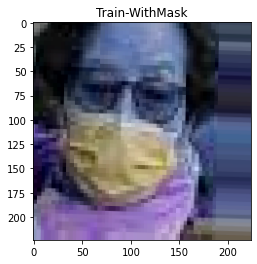

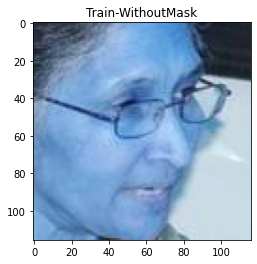

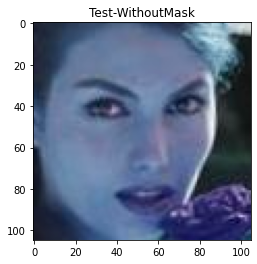

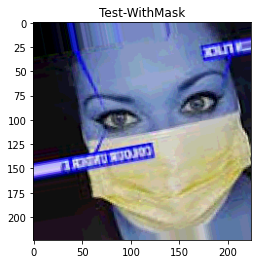

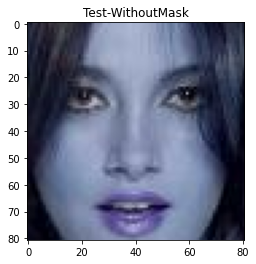

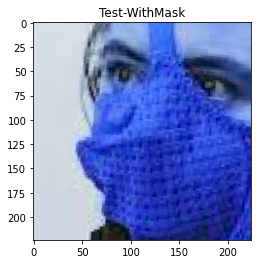

In [8]:
plot_images(validation_data)
plot_images(train_data)
plot_images(test_data)

# Image Data Preprocessing

1. **Index column is dropped**
2. **Images are turned to Grayscale using cv2**
3. **Resizing images to 150,150**
4. **Labels are encoded based on if it has the string "WithMask"**
5. **X and y are resized as 2D cupy arrays**
6. **X values are normalized to match the scales of all feature pixels**

In [9]:
def data_preprocessing(input_data):
    input_data = input_data.reset_index().drop("index", axis = 1)
    X = []
    y = []
    for idx,i in enumerate(range(len(input_data))):
        if idx%500 == 0:
            print(f'{idx} completed')
        img_array = cv2.imread(input_data["image_path"][i], cv2.IMREAD_GRAYSCALE)
        new_image_array = cv2.resize(img_array, (150, 150))
        X.append(new_image_array)
        if 'label' in input_data.columns:
            if input_data["label"][i] == "WithMask":
                y.append(1)
            else:
                y.append(0)
    clear_output()
    del img_array
    del new_image_array
    X = cp.array(X,dtype='float32').reshape(len(input_data),-1)
    y = cp.array(y).reshape(-1,1)
    X = X/255.0
    return X,y

### %%time is done as it is an expensive operation iterating over 3+ GB of data

In [10]:
%%time
Train_data,Train_labels = data_preprocessing(train_data)
Validation_data, Validation_labels = data_preprocessing(validation_data)
Test_data,_ = data_preprocessing(test_data)

CPU times: user 1min 50s, sys: 2.58 s, total: 1min 53s
Wall time: 3min 15s


### Subsequent GPU memory is also checked

In [11]:
!nvidia-smi

Fri Mar 18 14:22:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    34W / 250W |   1699MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# DIRECT CUML MODEL - Random Forest Classifier

### Below params were obtained by using nested loops as GridSearchCV is not available in Cuml and since CUML forest models are GPU Memory intensive and takes 20+ seconds for training

#### SETTING RANDOM_SEED DOES NOT GUARANTEE REPRODUCIBLE RESULTS AS PER CUML DOCS ALTHOUGH THE RESULTS PRODUCED RANGE UPTO 0.5 IN SCORE

In [12]:
params={
    'n_estimators':200,
    'min_samples_split':5,
    'n_bins': 256,
    'min_samples_split': 3,
    'random_state':42
}

#### Resizing is done as per requirement of the metrics functions

ROC_AUC_SCORE is stored as ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes.

MEAN_SQUARED_LOG_ERROR is stored as it is one of the famous metrics used for scoring on Kaggle

CONFUSION MATRIX gives up the number of TP,FP,TN,FN

The precision-recall curve shows the tradeoff between precision and recall for different threshold

In [13]:
%%time
clf=RandomForestClassifier(**params)
clf.fit(Train_data,Train_labels)
y_pred=clf.predict(Validation_data)
rac=roc_auc_score(Validation_labels,y_pred)
confm=confusion_matrix(Validation_labels.flatten().astype('int32'),y_pred.flatten().astype('int32'))
msle=mean_squared_log_error(Validation_labels.flatten().astype('int64'),y_pred.flatten().astype('int64'))
print(rac)
print(msle)
print(precision_recall_curve(Validation_labels,y_pred))
print(confm)
model_metrics['Random Forest Classifier']={'ROC_AUC_SCORE':rac,'MEAN_SQUARED_LOG_ERROR':msle,'CONFUSION_MATRIX':confm}
!nvidia-smi
final_predictions=clf.predict(Test_data)
del clf

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:794: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams==1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


0.9312499761581421
0.03303114470687635
(array([0.5       , 0.91970801, 1.        ]), array([1.        , 0.94499999, 0.        ]), array([0., 1.], dtype=float32))
[[367  33]
 [ 22 378]]
Fri Mar 18 14:23:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    36W / 250W |   1751MiB / 16280MiB |      0%      Default |
|                               |                      |       

### Checking final classification metrics for Random Forest

In [14]:
print(classification_report(Validation_labels.get(),y_pred.get()))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       400
           1       0.92      0.94      0.93       400

    accuracy                           0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.93       800



## Example of how the params were determined

In [15]:
%%time
score=0
best_params={}
for i in [2,3,5]:
#     for j in [1,0.5,0.25]:
    clf=RandomForestClassifier(random_state=20,min_samples_split=i)
    clf.fit(Train_data,Train_labels)
    y_pred=clf.predict(Validation_data)
    rac=roc_auc_score(Validation_labels,y_pred)
    if rac > score:
        score = rac
        best_params = clf.get_params()
    del clf
    del y_pred
    del rac
    print('done')

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:794: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams==1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


done
done
done
CPU times: user 1min 17s, sys: 3.44 s, total: 1min 20s
Wall time: 47 s


In [16]:
score,best_params

(0.9325000047683716,
 {'handle': <cuml.raft.common.handle.Handle at 0x7f394408e870>,
  'verbose': 4,
  'output_type': 'input',
  'n_estimators': 100,
  'max_depth': 16,
  'max_features': 'auto',
  'n_bins': 128,
  'split_criterion': 0,
  'min_samples_leaf': 1,
  'min_samples_split': 3,
  'min_impurity_decrease': 0.0,
  'bootstrap': True,
  'max_samples': 1.0,
  'max_leaves': -1,
  'accuracy_metric': None,
  'max_batch_size': 4096,
  'n_streams': 4,
  'dtype': dtype('float32'),
  'min_weight_fraction_leaf': None,
  'n_jobs': None,
  'max_leaf_nodes': None,
  'min_impurity_split': None,
  'oob_score': None,
  'random_state': 20,
  'warm_start': None,
  'class_weight': None,
  'criterion': None})

# Indirect CUML Model using Deep Learning - CNN Model using Tensorflow and Keras

In [17]:
from tensorflow import keras
from tensorflow.keras import layers,callbacks
from keras.metrics import MSLE

1. CNN  also known as [Convolutional Neural Network](https://www.ibm.com/cloud/learn/convolutional-neural-networks) is used by making 64, 128, 256 filters sequentially to generate filters that can predict high level features like mask colour, mask strap etc and then further lower level features like textures. Stride of 2 steps is done both horizontally and vertically
2. Max Pooling is done with each new unit having 3x3 image of the original
1. [Batch Normalization](https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/) is done for layer to layer regularization. 
1. ReLU is used to prevent [Vanishing Gradients problem.](https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484)

In [18]:
model = keras.Sequential([
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(256,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dense(1,activation='sigmoid')
])

2022-03-18 14:24:38.877211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 14:24:38.881849: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 14:24:38.882527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 14:24:38.883681: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

1. Adam optimizer is used as an optimisation algorithm.
1. Cross Entropy Loss is calculated as a cost/loss function for the classification problem.
1. Most previously relevant metrics are calculated for all epochs for visualisation purposes. 

In [19]:
model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics = ['binary_accuracy','Recall','Precision',MSLE,'AUC'])

1. X values are reshaped as images with 1 channel of colour = 1 and converted into Numpy arrays for indirect passing
1. target values are reshaped as 1D numpy arrays

In [20]:
X_train = Train_data.reshape((-1,150,150,1)).get()
X_test = Validation_data.reshape((-1,150,150,1)).get()
y_train = Train_labels.flatten().get()
y_test = Validation_labels.flatten().get()

In [21]:
type(X_train),type(y_train),type(X_test),type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

Data is passed in batches of 32 each size and for training cycles or epochs of 25
All of the metrics obtained in each epoch are stored in history which is a Keras object

In [22]:
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),
                    batch_size = 32, epochs=25)

2022-03-18 14:24:39.560269: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 900000000 exceeds 10% of free system memory.
2022-03-18 14:24:40.476015: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 900000000 exceeds 10% of free system memory.
2022-03-18 14:24:41.122098: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-03-18 14:24:44.031831: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


313/313 [==============================] - 22s 41ms/step - loss: 23.4496 - binary_accuracy: 0.8622 - recall: 0.8646 - precision: 0.8605 - mean_squared_logarithmic_error: 0.0586 - auc: 0.9028 - val_loss: 311.3103 - val_binary_accuracy: 0.5412 - val_recall: 0.0825 - val_precision: 1.0000 - val_mean_squared_logarithmic_error: 0.2204 - val_auc: 0.5412
Epoch 2/25
313/313 [==============================] - 12s 39ms/step - loss: 12.8216 - binary_accuracy: 0.9297 - recall: 0.9240 - precision: 0.9347 - mean_squared_logarithmic_error: 0.0334 - auc: 0.9328 - val_loss: 1.2559 - val_binary_accuracy: 0.9737 - val_recall: 0.9700 - val_precision: 0.9773 - val_mean_squared_logarithmic_error: 0.0129 - val_auc: 0.9748
Epoch 3/25
313/313 [==============================] - 12s 39ms/step - loss: 0.8712 - binary_accuracy: 0.9735 - recall: 0.9696 - precision: 0.9772 - mean_squared_logarithmic_error: 0.0123 - auc: 0.9784 - val_loss: 0.2949 - val_binary_accuracy: 0.9737 - val_recall: 0.9750 - val_precision: 0.9

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 74, 64)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 36, 128)       896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 256)       2

preparing the data for further metrics functions

In [24]:
y_pred=cp.array(model.predict(X_test),dtype='int32').flatten()
y_test=cp.array(y_test, dtype='int32').flatten()
y_pred.shape,y_test.shape

((800,), (800,))

**F1 Score is calculated for each epoch. It is a way of combining the precision and recall of the model with equal importance, and it is defined as the harmonic mean of the model’s precision and recall**

In [25]:
f1_scores=[(2*a*b)/(a+b) for a,b in zip(history.history['val_precision'],history.history['val_recall'])]
print(f1_scores)

[0.152424947858497, 0.9736512037007254, 0.9737827799249953, 0.9887359152209546, 0.9801488926738203, 0.9836888412427938, 0.9802955557065428, 0.9838509370568661, 0.9863354011494584, 0.9887920290417458, 0.9331742298091007, 0.9899749559996447, 0.9836065797903648, 0.9862327922732587, 0.9839703995729304, 0.9786163592215016, 0.9874055375348467, 0.9848866695568359, 0.9886792516468832, 0.9887359152209546, 0.9899749559996447, 0.9899749559996447, 0.9899749559996447, 0.9899749559996447, 0.9899749559996447]


### Visualizing DL model metrics

Text(0, 0.5, 'Score')

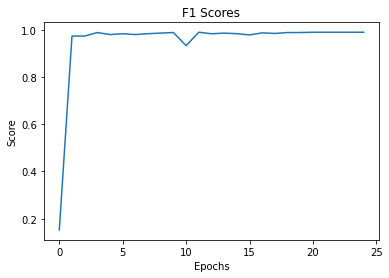

In [26]:
plt.plot(f1_scores)
plt.title('F1 Scores')
plt.xlabel('Epochs')
plt.ylabel('Score')

Text(0, 0.5, 'Score')

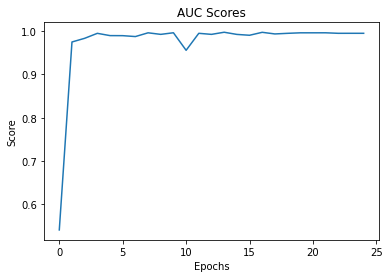

In [27]:
plt.plot(history.history['val_auc'])
plt.title('AUC Scores')
plt.xlabel('Epochs')
plt.ylabel('Score')

Text(0, 0.5, 'Errors')

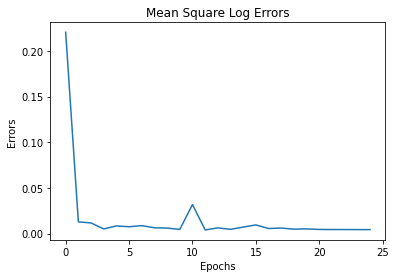

In [28]:
plt.plot(history.history['val_mean_squared_logarithmic_error'])
plt.title('Mean Square Log Errors')
plt.xlabel('Epochs')
plt.ylabel('Errors')

Text(0, 0.5, 'Score')

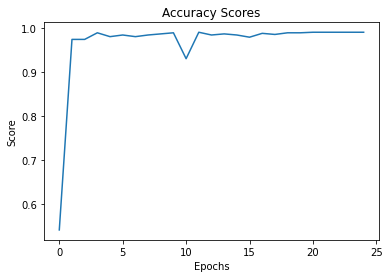

In [29]:
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy Scores')
plt.xlabel('Epochs')
plt.ylabel('Score')

### Storing the comparable metrics

In [30]:
AUC=history.history['val_auc'][-1]
msle=history.history['val_mean_squared_logarithmic_error'][-1]
model_metrics['CNN']={'AUC':AUC, 'MEAN_SQUARED_LOG_ERROR':msle,'F1_SCORE':f1_scores[-1]}

In [31]:
rac=roc_auc_score(y_test,y_pred)
print(rac)
model_metrics['CNN']['ROC_AUC_SCORE']=rac

0.9449999928474426


DL Model shows very less type 1 error

In [32]:
conf=confusion_matrix(y_test,y_pred)
print(conf)
model_metrics['CNN']['CONFUSION_MATRIX']=conf

[[400   0]
 [ 44 356]]


In [33]:
print(classification_report(y_test.get(),y_pred.get()))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       400
           1       1.00      0.89      0.94       400

    accuracy                           0.94       800
   macro avg       0.95      0.95      0.94       800
weighted avg       0.95      0.94      0.94       800



In [34]:
precision_recall_curve(y_test,y_pred)

(array([0.5, 1. , 1. ]),
 array([1.        , 0.88999999, 0.        ]),
 array([0, 1], dtype=int32))

## CNN Model is better than Random Forest since it is making lesser type 1 error and has lesser MSLE

In [35]:
model_metrics

{'Random Forest Classifier': {'ROC_AUC_SCORE': 0.9312499761581421,
  'MEAN_SQUARED_LOG_ERROR': array(0.03303114),
  'CONFUSION_MATRIX': array([[367,  33],
         [ 22, 378]])},
 'CNN': {'AUC': 0.9947875738143921,
  'MEAN_SQUARED_LOG_ERROR': 0.004391274880617857,
  'F1_SCORE': 0.9899749559996447,
  'ROC_AUC_SCORE': 0.9449999928474426,
  'CONFUSION_MATRIX': array([[400,   0],
         [ 44, 356]])}}

In [36]:
final_predictions_DL=model.predict(Test_data.reshape((-1,150,150,1)).get()).astype('int').flatten()

### Checking GPU Memory to see if another dataframe can be made

In [37]:
!nvidia-smi

Fri Mar 18 14:30:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    51W / 250W |  15973MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Final predictions using both models

In [38]:
final_df=cd.DataFrame({'Random Forest':final_predictions.astype('int'),'CNN Model':final_predictions_DL})
final_df

,Random Forest,CNN Model
0,0,0
1,0,1
2,0,0
3,1,1
4,0,0
...,...,...
987,1,1
988,0,0
989,1,0
990,0,0
